In [193]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#import packages for w2v
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [194]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

# Data Preprocessing

In [195]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [196]:
import datetime
filtered_data["Time"]=pd.to_datetime(filtered_data["Time"], format='%Y-%m-%d %H:%M:%S')

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [197]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [198]:
#sording data by timestamp so that it can be divided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

print(final.shape)

(364173, 10)


(2000, 10)


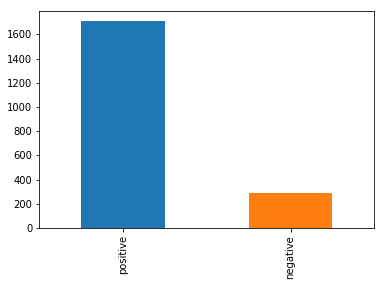

In [199]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final=final.sample(2000, replace=True)
print(final.shape)

#To know how many positive and negative reviews are present in our dataset
final['Score'].value_counts()
final['Score'].value_counts().plot(kind='bar')

# Removing stopwords, punctuation and then we do stemming

In [241]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'themselves', 'has', 'himself', 'are', 'just', 'how', 'than', 'not', 'can', 'my', 'hadn', "mustn't", 'only', 'his', "hasn't", 'her', 'yours', "couldn't", "doesn't", 'over', 'needn', 'with', 'through', 'against', 'all', 'shan', 'to', 'other', 'haven', 'am', 'of', 'm', 'where', 'don', "should've", "wasn't", 'or', 'no', 'won', 'out', "shan't", 'doing', 'itself', 'same', 'very', 'they', 'was', "hadn't", 'our', 'having', 'him', 'its', 'she', 'why', 'theirs', 'should', 'i', 'the', 'wouldn', 'hers', 'yourself', "wouldn't", 'now', 'does', 'be', 'and', 'those', 'll', 'them', 'hasn', 'wasn', 'ma', "aren't", "it's", 'in', 'while', 'above', 'on', 'some', 'myself', 'weren', 'couldn', 'further', 'herself', "that'll", 'at', 'so', 'we', 'if', 'these', 'own', 't', "you'll", 'is', 'had', 'it', 'doesn', 'this', 'because', 'mightn', 'aren', 's', 'once', "haven't", 'down', 'what', 'yourselves', 'each', 'until', 'any', 'again', 'during', 'here', 'ain', 'when', 'about', "didn't", 'by', 'isn', 'were', 'befor

In [201]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [202]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
print(final['CleanedText'])

181895    best tast honey ive ever orang blossom delic e...
151670    take get use use flour made wheat year slight ...
27863     favorit rice roni cook easili make enough righ...
25045     princ tea brand tea great premium oolong tea g...
262914    puppi seem like work well assist train seem fr...
245685    absolut wonder chocol exist chocol lover top e...
359717    product delish two kid hubbi love fruit leathe...
165080    old min pin sudden stop eat regular brand food...
176691    item requir refriger ship kentucki weather war...
354832    anoth hit red leaf red leaf great vendor suppl...
141803    great coffe purchas bag aw lot coffe two peopl...
292211    sad incred candi gem total addict els say stop...
340417    tri mani coffe variti settl green mountain nan...
174617    one best chocol eaten long time would recommen...
25541     current favorit tea basic given lipton tea tri...
263765    never tast nutro ultra dri puppi food dog thri...
169218    syrup cassi hard find peopl se

In [203]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [216]:
#method for finding optimal value of alpha
from sklearn.cross_validation import cross_val_score
#from sklearn.naive_bayes.MultinomialNB
from sklearn.naive_bayes import BernoulliNB

#MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

def find_optimal_alpha(X_train,y_train):
   
    # empty list that will hold cv scores
    cv_scores = []
    myList = list(range(0,100))
    # split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)

    for i in myList:
        nb = BernoulliNB(alpha = i)
        model = nb.fit(X_tr, y_tr)

        # predict the response on the crossvalidation train
        pred = model.predict(X_cv)

        # evaluate CV accuracy
        acc = accuracy_score(y_cv, pred, normalize=True)
        cv_scores.append(acc)
        
    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = myList[MSE.index(min(MSE))]
    print('\nThe optimal alpha is ', optimal_alpha)


    plt.figure(figsize=(10,6))
    plt.plot(myList,MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. alpha Value')
    plt.xlabel('alpha')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_alpha


In [217]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
def confusion_matrix_plot(y_test,pred):
    labels = ['negative','positive']
    cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    #fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Splitting and saving the data into respective files

In [218]:
X = final['CleanedText']
y = final['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [219]:
# save the data to disk
"""import pickle
filename1 = 'train_data.sav'
pickle.dump(X_train, open(filename1, 'wb'))

filename2 = 'test_data.sav'
pickle.dump(X_test, open(filename2, 'wb'))

X_train1 = pickle.load(open(filename1, 'rb'))
X_test1 = pickle.load(open(filename2, 'rb'))
import math

X_train =  X[:math.ceil(len(final)*.7)] 
X_test = X[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]"""

"import pickle\nfilename1 = 'train_data.sav'\npickle.dump(X_train, open(filename1, 'wb'))\n\nfilename2 = 'test_data.sav'\npickle.dump(X_test, open(filename2, 'wb'))\n\nX_train1 = pickle.load(open(filename1, 'rb'))\nX_test1 = pickle.load(open(filename2, 'rb'))\nimport math\n\nX_train =  X[:math.ceil(len(final)*.7)] \nX_test = X[math.ceil(len(final)*.7):]\ny_train = y[:math.ceil(len(final)*.7)]\ny_test =  y[math.ceil(len(final)*.7):]"

# Bag of Words

In [220]:
count_vect = CountVectorizer(ngram_range=(1,2)) 
final_bow_count = count_vect.fit_transform(X_train)

In [221]:
print(final_bow_count.shape)

(1400, 46399)


In [222]:
y_train.shape

(1400,)

In [223]:
#final_y_train = count_vect.fit_transform(y_train)
#final_y_test = count_vect.transform(y_test)
y_test.shape

(600,)

In [224]:
X_test_vec= count_vect.transform(X_test)
X_test_vec.shape

(600, 46399)


The optimal alpha is  6
the misclassification error for each k value is :  [0.16  0.157 0.15  0.15  0.15  0.15  0.148 0.148 0.148 0.148 0.148 0.148
 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148
 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148
 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148
 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148
 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148
 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148
 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148
 0.148 0.148 0.148 0.148]
6


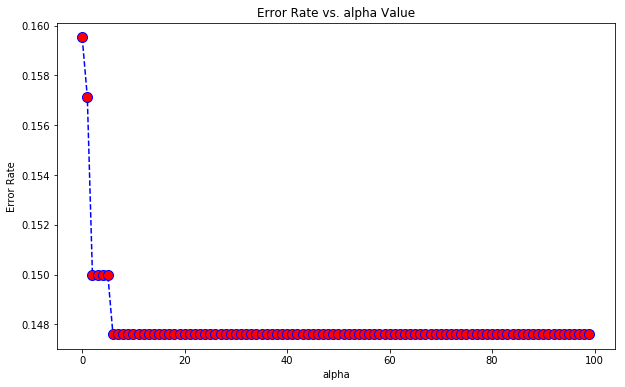

In [225]:
from sklearn import cross_validation

optimal_alpha = find_optimal_alpha(final_bow_count,y_train)

print(optimal_alpha)

In [226]:
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB

nb = BernoulliNB(alpha=optimal_alpha)
nb.fit(final_bow_count, y_train)
pred = nb.predict(X_test_vec)
# y_test = count_vect.fit_transform(y_test)
acc = accuracy_score(y_test, pred) * 100
train_error=nb.score(final_bow_count, y_train)
test_error=nb.score(X_test_vec, y_test)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_alpha, acc))


The accuracy of the knn classifier for k = 6 is 85.833333%


[[  0  85]
 [  0 515]]


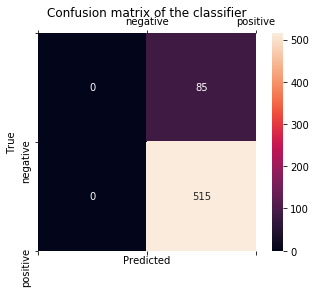

In [227]:
confusion_matrix_plot(y_test,pred)

# Important Features

In [228]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

#Sorting the features in the order of importance and printing the top 10 features
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

['aarp' 'paid local' 'paid premium' 'paid set' 'paid ship' 'paid starbuck'
 'paid walmart' 'paid way' 'paid last' 'pain deliv']
['problem bat' 'bud final' 'bud clear' 'think energi' 'prepar even'
 'think explain' 'flavor fast' 'new england' 'prepar ingredi' 'think hard']


In [229]:
#Printing Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00        85
   positive       0.86      1.00      0.92       515

avg / total       0.74      0.86      0.79       600



In [230]:
#Printing final results
from astropy.table import Table, Column
t = Table(names=( "Hyper parameter", "Train error","Test error"), dtype=('i4', 'f4', 'f4'))
t.add_row((optimal_alpha, train_error, test_error))
print(t)

Hyper parameter Train error Test error
--------------- ----------- ----------
              6   0.8528572 0.85833335


# TF-IDF

In [143]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))
final_tfidf_count = tf_idf_vec.fit_transform(X_train)

In [144]:
from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count)
X_test_dtm = tf_idf_vec.transform(X_test)


The optimal alpha is  1e-05
the misclassification error for each k value is :  [0.14  0.169 0.179 0.179 0.179 0.19  0.195 0.198 0.21  0.214 0.214 0.214
 0.224 0.231 0.229 0.231 0.233 0.24  0.248 0.25 ]


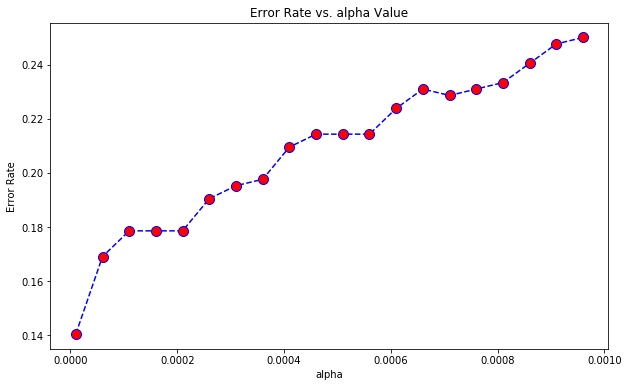

In [145]:
optimal_alpha = find_optimal_alpha(final_tfidf_count,y_train)

In [235]:
nb = BernoulliNB(alpha=optimal_alpha)
nb.fit(final_tfidf_np, y_train)
pred = nb.predict(X_test_dtm)
acc = accuracy_score(y_test, pred) * 100
train_error=nb.score(final_tfidf_np, y_train)
test_error=nb.score(X_test_dtm, y_test)
print('\nThe accuracy of the knn classifier for alpha = %d is %f%%' % (optimal_alpha, acc))


The accuracy of the knn classifier for alpha = 6 is 85.833333%


[[ 66  55]
 [  1 478]]


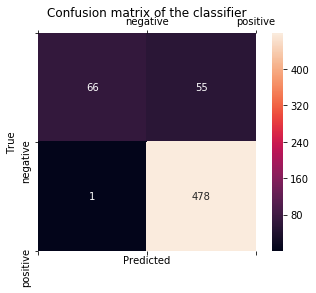

In [147]:
confusion_matrix_plot(y_test,pred)

In [186]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

#Sorting the features in the order of importance and printing the top 10 features
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

['aaaaawsom' 'packag left' 'packag last' 'packag keep' 'packag item'
 'packag instead' 'packag individu' 'packag ill' 'packag howev'
 'packag hold']
['inde becom' 'nap hit' 'fortifi blend' 'clear equal' 'clear color' 'nap'
 'clear bag' 'someth differ' 'someth doesnt' 'someth eat']


In [187]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.96      0.56      0.71       121
   positive       0.90      0.99      0.94       479

avg / total       0.91      0.91      0.90       600



# Avg W2V

In [148]:
import gensim
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in X_train.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())
    
i=0
list_of_sent=[]
for sent in X_Train.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [149]:
# can you scroll up to that error
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
words = list(w2v_model.wv.vocab)

In [188]:
sent_vectors = [];    
for sent in X_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_train_Vectorised = sent_vectors

sent_vectors = [];    
for sent in X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_test_Vectorised = sent_vectors

np.where(np.isnan(X_test_Vectorised))
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)

In [189]:
"""scaler = StandardScaler()
#X = sent_vectors
#y = final['Score']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#scaler = StandardScaler()
scaler1=scaler.fit(X_train_Vectorised)
final_w2v_count = scaler1.transform(X_train_Vectorised)
X_test_vec = scaler.transform(X_test_Vectorised)
print(final_w2v_count.shape)
print(X_test_vec.shape)"""



"scaler = StandardScaler()\n#X = sent_vectors\n#y = final['Score']\n#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)\n#scaler = StandardScaler()\nscaler1=scaler.fit(X_train_Vectorised)\nfinal_w2v_count = scaler1.transform(X_train_Vectorised)\nX_test_vec = scaler.transform(X_test_Vectorised)\nprint(final_w2v_count.shape)\nprint(X_test_vec.shape)"


The optimal alpha is  1e-05
the misclassification error for each k value is :  [0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183
 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183]


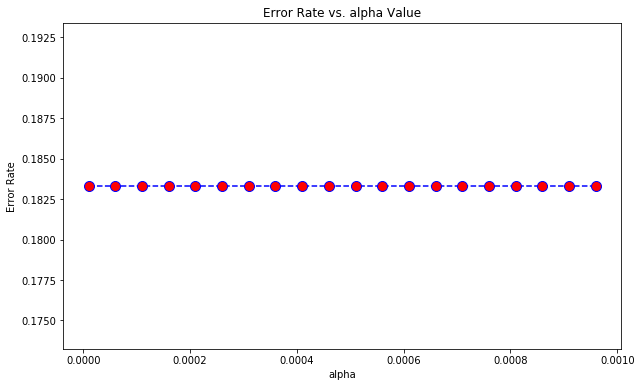

In [190]:
optimal_alpha = find_optimal_alpha(X_train_Vectorised,y_train)

In [236]:
nb = BernoulliNB(alpha=optimal_alpha)
nb.fit(X_train_Vectorised, y_train)
pred = nb.predict(X_test_Vectorised)
acc = accuracy_score(y_test, pred) * 100
train_error=nb.score(X_train_Vectorised, y_train)
test_error=nb.score(X_test_Vectorised, y_test)
print('\nThe accuracy of the knn classifier for alpha = %d is %f%%' % (optimal_alpha, acc))


The accuracy of the knn classifier for alpha = 6 is 85.833333%


[[  0 121]
 [  0 479]]


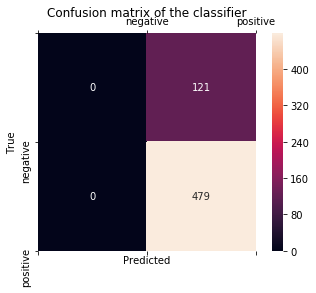

In [192]:
confusion_matrix_plot(y_test,pred)

In [231]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00        85
   positive       0.86      1.00      0.92       515

avg / total       0.74      0.86      0.79       600



# TF-IDF W2V

In [232]:
tf_idf_vec_w = TfidfVectorizer()

final_tfidf_w = tf_idf_vec_w.fit_transform(final_string_for_tfidf)
tfidf_feature = tf_idf_vec_w.get_feature_names()
tfidf_sent_vectors = [];
row=0;
for sent in X_train.values:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feature.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1
X_train_Vectorised = tfidf_sent_vectors

In [233]:
tfidf_sent_vectors = [];
row=0;
for sent in X_test.values:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feature.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_test_Vectorised = tfidf_sent_vectors

np.where(np.isnan(X_test_Vectorised))
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)

In [237]:
nb = BernoulliNB(alpha=optimal_alpha)
nb.fit(X_train_Vectorised, y_train)
pred = nb.predict(X_test_Vectorised)
acc = accuracy_score(y_test, pred) * 100
train_error=nb.score(X_train_Vectorised, y_train)
test_error=nb.score(X_test_Vectorised, y_test)
print('\nThe accuracy of the knn classifier for alpha = %d is %f%%' % (optimal_alpha, acc))


The accuracy of the knn classifier for alpha = 6 is 85.833333%


[[  0  85]
 [  0 515]]


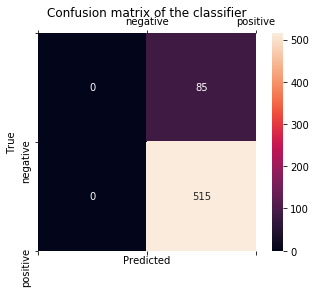

In [238]:
confusion_matrix_plot(y_test,pred)

In [239]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00        85
   positive       0.86      1.00      0.92       515

avg / total       0.74      0.86      0.79       600

